# Import required libraries

In [5]:
import zipfile
import os
import shutil
from pathlib import Path

In [6]:
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load data

In [7]:
from PIL import Image

data_dir = Path("/kaggle/input/watste-data1/data")

image_paths = []
labels = []
image_shapes = []

for class_dir in data_dir.iterdir():
    if class_dir.is_dir():
        for img_path in class_dir.glob("*"):
            image_paths.append(str(img_path))
            labels.append(class_dir.name)
            try:
                with Image.open(img_path) as img:
                    image_shapes.append(img.size)
            except Exception as e:
                print(f"Error loading {img_path}: {e}")



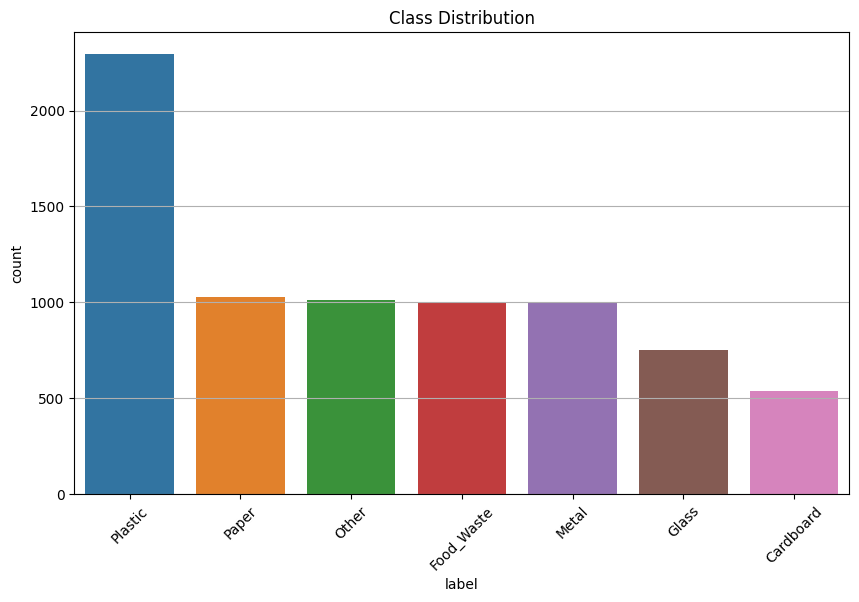

In [8]:
df = pd.DataFrame({"label": labels})
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x="label", order=df["label"].value_counts().index)
plt.title("Class Distribution")
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()


## We can see that there is class imbalance and `plastic` has more images than rest of the categories

Sample from class: Cardboard


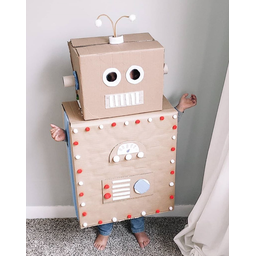

Sample from class: Food_Waste


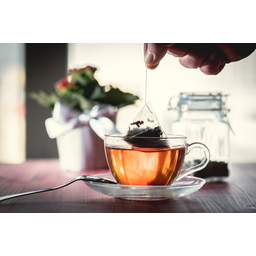

Sample from class: Glass


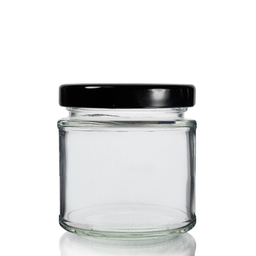

Sample from class: Metal


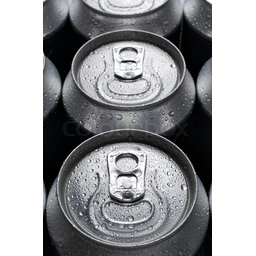

Sample from class: Other


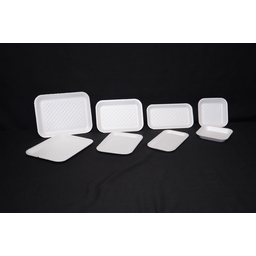

Sample from class: Paper


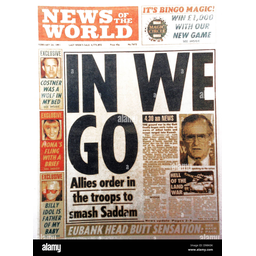

Sample from class: Plastic


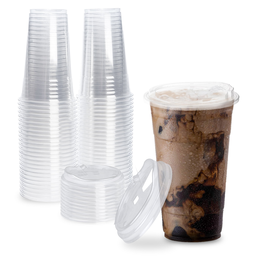

In [9]:
import random
from IPython.display import display

unique_labels = sorted(set(labels))
sample_per_class = 1

for label in unique_labels:
    print(f"Sample from class: {label}")
    sample_paths = [p for p, l in zip(image_paths, labels) if l == label]
    random.shuffle(sample_paths)
    
    for img_path in sample_paths[:sample_per_class]:
        img = Image.open(img_path)
        display(img)


In [10]:
widths, heights = zip(*image_shapes)

print("Image Size Stats:")
print(f"Min size:     {min(widths)} x {min(heights)}")
print(f"Max size:     {max(widths)} x {max(heights)}")
print(f"Average size: {int(sum(widths)/len(widths))} x {int(sum(heights)/len(heights))}")

Image Size Stats:
Min size:     256 x 256
Max size:     256 x 256
Average size: 256 x 256


## All the images are of size (256,256,3) there is no need to alter the images

In [11]:
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)
num_classes = len(label_encoder.classes_)

# Train test split

In [12]:
train_paths, val_paths, train_labels, val_labels = train_test_split(
    image_paths, labels_encoded, test_size=0.2, stratify=labels_encoded, random_state=42
)

# Custom CNN model with 13 layers

In [13]:
IMG_SIZE = 256
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE

def load_image(path, label, augment=False):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
    image = image / 255.0
    if augment:
        image = tf.image.random_flip_left_right(image)
        image = tf.image.random_brightness(image, max_delta=0.1)
    return image, label

train_ds = tf.data.Dataset.from_tensor_slices((train_paths, train_labels))
train_ds = train_ds.map(lambda x, y: load_image(x, y, augment=True), num_parallel_calls=AUTOTUNE)
train_ds = train_ds.shuffle(1000).batch(BATCH_SIZE).prefetch(AUTOTUNE)

val_ds = tf.data.Dataset.from_tensor_slices((val_paths, val_labels))
val_ds = val_ds.map(load_image, num_parallel_calls=AUTOTUNE).batch(BATCH_SIZE).prefetch(AUTOTUNE)

In [14]:
model = models.Sequential([
    layers.Conv2D(16, (3, 3), activation='relu', padding='same', input_shape=(256, 256, 3)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),

    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),

    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),

    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 256, 256, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 256, 256, 16)        │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 128, 128, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 128, 128, 32)        │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 128, 128, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 64, 64, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 64, 64, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 65536)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 256)                 │      16,777,472 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 7)                   │           1,799 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 16,803,303 (64.10 MB)

 Trainable params: 16,803,079 (64.10 MB)

 Non-trainable params: 224 (896.00 B)

In [15]:
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=5, restore_best_weights=True
)

lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6
)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=25,
    callbacks=[early_stop, lr_scheduler]
)


Epoch 1/25


I0000 00:00:1745396906.178026      75 service.cc:148] XLA service 0x7d0918010710 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1745396906.178876      75 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1745396906.585967      75 cuda_dnn.cc:529] Loaded cuDNN version 90300


  5/191 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - accuracy: 0.2247 - loss: 3.7558 

I0000 00:00:1745396910.817911      75 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


191/191 ━━━━━━━━━━━━━━━━━━━━ 22s 66ms/step - accuracy: 0.2925 - loss: 2.7622 - val_accuracy: 0.2407 - val_loss: 3.0031 - learning_rate: 1.0000e-04
Epoch 2/25
191/191 ━━━━━━━━━━━━━━━━━━━━ 9s 41ms/step - accuracy: 0.3897 - loss: 1.6337 - val_accuracy: 0.3384 - val_loss: 1.9610 - learning_rate: 1.0000e-04
Epoch 3/25
191/191 ━━━━━━━━━━━━━━━━━━━━ 10s 46ms/step - accuracy: 0.4190 - loss: 1.5405 - val_accuracy: 0.4623 - val_loss: 1.4593 - learning_rate: 1.0000e-04
Epoch 4/25
191/191 ━━━━━━━━━━━━━━━━━━━━ 9s 39ms/step - accuracy: 0.4493 - loss: 1.4465 - val_accuracy: 0.4997 - val_loss: 1.3897 - learning_rate: 1.0000e-04
Epoch 5/25
191/191 ━━━━━━━━━━━━━━━━━━━━ 9s 41ms/step - accuracy: 0.4820 - loss: 1.3731 - val_accuracy: 0.5344 - val_loss: 1.3036 - learning_rate: 1.0000e-04
Epoch 6/25
191/191 ━━━━━━━━━━━━━━━━━━━━ 11s 50ms/step - accuracy: 0.5352 - loss: 1.2100 - val_accuracy: 0.5403 - val_loss: 1.3104 - learning_rate: 1.0000e-04
Epoch 7/25
191/191 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 

48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.6777 - loss: 1.1098
Validation Accuracy: 0.6728


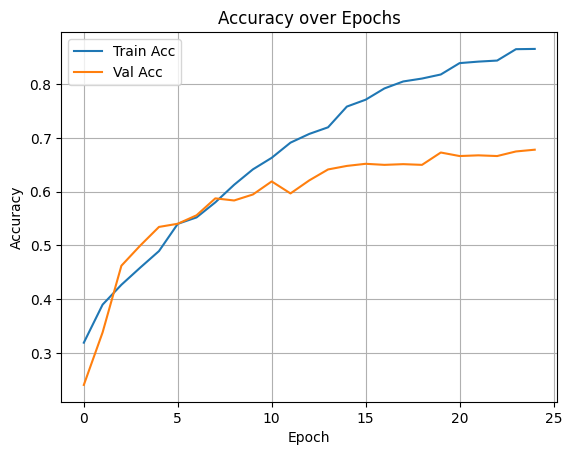

In [16]:
val_loss, val_acc = model.evaluate(val_ds)
print(f"Validation Accuracy: {val_acc:.4f}")

plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title("Accuracy over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()
plt.show()


## Custom model final accuracy is 67.82%

# Pretrained model - EfficientNetB3

In [17]:
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras import layers, models

IMG_SIZE = 256
num_classes = 7

base_model = EfficientNetB3(input_shape=(IMG_SIZE, IMG_SIZE, 3), include_top=False, weights='imagenet')
base_model.trainable = False

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.4),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(num_classes, activation='softmax')
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [18]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    callbacks=[early_stop]
)

Epoch 1/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 87s 243ms/step - accuracy: 0.2699 - loss: 1.9045 - val_accuracy: 0.3010 - val_loss: 1.8500
Epoch 2/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 17s 81ms/step - accuracy: 0.2932 - loss: 1.8761 - val_accuracy: 0.3010 - val_loss: 1.8541
Epoch 3/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 16s 78ms/step - accuracy: 0.2905 - loss: 1.8728 - val_accuracy: 0.3010 - val_loss: 1.8499
Epoch 4/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 16s 77ms/step - accuracy: 0.2962 - loss: 1.8708 - val_accuracy: 0.3010 - val_loss: 1.8499
Epoch 5/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 16s 78ms/step - accuracy: 0.2930 - loss: 1.8620 - val_accuracy: 0.3010 - val_loss: 1.8481
Epoch 6/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 16s 77ms/step - accuracy: 0.2953 - loss: 1.8698 - val_accuracy: 0.3010 - val_loss: 1.8492
Epoch 7/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 16s 78ms/step - accuracy: 0.2929 - loss: 1.8615 - val_accuracy: 0.3010 - val_loss: 1.8467
Epoch 8/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 16s 77ms/step - accuracy: 0.3006 - loss: 1.8576 -

In [19]:
base_model.trainable = True

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

fine_history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=5,
    callbacks=[early_stop]
)

Epoch 1/5


E0000 00:00:1745397633.692752      76 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1745397633.890021      76 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1745397634.454593      76 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1745397634.672657      76 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1745397635.079041      76 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:0

190/191 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step - accuracy: 0.1685 - loss: 2.2062

E0000 00:00:1745397730.902698      76 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1745397731.095747      76 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1745397731.616196      76 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1745397731.837225      76 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1745397732.232253      76 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:0

191/191 ━━━━━━━━━━━━━━━━━━━━ 248s 600ms/step - accuracy: 0.1689 - loss: 2.2047 - val_accuracy: 0.2970 - val_loss: 1.8785
Epoch 2/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 53s 271ms/step - accuracy: 0.3207 - loss: 1.7644 - val_accuracy: 0.3207 - val_loss: 1.7546
Epoch 3/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 53s 271ms/step - accuracy: 0.4591 - loss: 1.4979 - val_accuracy: 0.5416 - val_loss: 1.4045
Epoch 4/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 53s 272ms/step - accuracy: 0.5506 - loss: 1.2994 - val_accuracy: 0.6721 - val_loss: 1.1024
Epoch 5/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 53s 272ms/step - accuracy: 0.6192 - loss: 1.1086 - val_accuracy: 0.7174 - val_loss: 0.9189


In [20]:
val_loss, val_acc = model.evaluate(val_ds)
print(f"Validation Accuracy: {val_acc:.4f}")

48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - accuracy: 0.7199 - loss: 0.9116
Validation Accuracy: 0.7174


## Pretrained model final accuracy is 71.74%